In [1]:
import numba as nb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['figure.dpi'] = 300
import seaborn as sns
from scipy.interpolate import griddata
import os
import shutil
import moviepy as mp

In [2]:
SIM_NAME = 'Sim 3'

data = pd.read_csv(f'Output/{SIM_NAME}.csv', header=0)
data

,m,n,o,num_images,pos_rms,mag_rms,chi2,M,x,y,e,$θ_{e}$,c or $r_{s}$,NaN,source_x,source_y
0,20.0,0.0,0.00000,1,0.015992,5.207995e+07,584.3345,2.572966e+12,20.80809,20.77544,0.0,0.00000,20.0,0.0,20.80809,20.77544
1,20.0,0.0,3.63636,1,0.015992,5.207994e+07,584.3345,2.572966e+12,20.80809,20.77544,0.0,3.63636,20.0,0.0,20.80809,20.77544
2,20.0,0.0,7.27273,1,0.015992,5.207994e+07,584.3345,2.572966e+12,20.80809,20.77544,0.0,7.27273,20.0,0.0,20.80809,20.77544
3,20.0,0.0,10.90909,1,0.015992,5.207993e+07,584.3345,2.572966e+12,20.80809,20.77544,0.0,10.90909,20.0,0.0,20.80809,20.77544
4,20.0,0.0,14.54545,1,0.015992,5.207995e+07,584.3345,2.572966e+12,20.80809,20.77544,0.0,14.54545,20.0,0.0,20.80809,20.77544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,100.0,0.9,349.09091,3,0.909761,4.222200e+00,196102.9000,2.849745e+11,20.78430,20.80028,0.9,349.09090,100.0,0.0,20.83794,20.93859
999996,100.0,0.9,360.00000,3,0.482400,4.223650e+00,151400.6000,2.660247e+11,20.82057,20.85391,0.9,360.00000,100.0,0.0,20.84058,20.96643
999997,100.0,0.9,338.18182,5,0.804214,4.219900e+00,345291.6000,1.662842e+11,20.75608,21.04306,0.9,338.18180,100.0,0.0,20.76848,21.05126
999998,100.0,0.9,352.72727,3,0.919854,4.222650e+00,145355.5000,2.722215e+11,20.78905,20.84271,0.9,352.72730,100.0,0.0,20.83187,20.95847


In [3]:
data['pos_rms'] = data['pos_rms'].fillna(1)
data['mag_rms'] = data['mag_rms'].fillna(6000)

In [14]:
data4 = data[(data['num_images'] == 4)]
pos_sigma = 0.001
mag_sigma = 1
sigma = 1000
datagood = data4[(data4['pos_rms'] < sigma*pos_sigma) & (data4['mag_rms'] < sigma*mag_sigma)]
datagood

,m,n,o,num_images,pos_rms,mag_rms,chi2,M,x,y,e,$θ_{e}$,c or $r_{s}$,NaN,source_x,source_y
103,20.0,0.00909,3.63636,4,0.554737,418.932867,4465.441,2.570004e+12,20.78500,20.76716,0.00909,3.63636,20.0,0.0,20.78466,20.76981
415,20.0,0.03636,65.45455,4,0.260571,782.424400,46045.730,2.326525e+12,20.90699,20.83987,0.03636,65.45455,20.0,0.0,20.90129,20.83385
1519,20.0,0.13636,80.00000,4,0.162327,20.216900,69329.240,3.289778e+12,20.83241,21.26213,0.13636,80.00000,20.0,0.0,20.83934,21.29793
1627,20.0,0.14545,80.00000,4,0.160752,18.541067,68278.050,3.321644e+12,20.83281,21.26216,0.14545,80.00000,20.0,0.0,20.84066,21.30077
1673,20.0,0.14545,261.81818,4,0.152380,18.549267,65137.190,3.309018e+12,20.83082,21.26117,0.14545,261.81820,20.0,0.0,20.83897,21.29937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998959,100.0,0.80909,214.54545,4,0.237522,4.110300,265102.600,4.254915e+11,20.63841,20.55584,0.80909,214.54540,100.0,0.0,20.34057,20.54461
999009,100.0,0.81818,36.36364,4,0.297886,3.791450,270107.900,4.341304e+11,20.63243,20.56096,0.81818,36.36364,100.0,0.0,20.33955,20.53618
999488,100.0,0.85455,312.72727,4,0.357727,3.695450,248491.800,7.504349e+11,20.84023,20.37546,0.85455,312.72730,100.0,0.0,21.28727,20.17370
999620,100.0,0.87273,61.81818,4,0.508670,3.882467,357701.900,1.862122e+11,20.66319,20.93887,0.87273,61.81818,100.0,0.0,20.62899,20.80596


In [16]:
print(data['c or $r_{s}$'].unique())
data_spes = data[data['c or $r_{s}$'] == 62.0202]

[ 20.       20.80808  21.61616  22.42424  23.23232  24.0404   24.84848
  25.65657  26.46465  27.27273  28.08081  28.88889  29.69697  30.50505
  31.31313  32.12121  32.92929  33.73737  34.54545  35.35354  36.16162
  36.9697   37.77778  38.58586  39.39394  40.20202  41.0101   41.81818
  42.62626  43.43434  44.24242  45.05051  45.85859  46.66667  47.47475
  48.28283  49.09091  49.89899  50.70707  51.51515  52.32323  53.13131
  53.93939  54.74747  55.55556  56.36364  57.17172  57.9798   58.78788
  59.59596  60.40404  61.21212  62.0202   62.82828  63.63636  64.44444
  65.25253  66.06061  66.86869  67.67677  68.48485  69.29293  70.10101
  70.90909  71.71717  72.52525  73.33333  74.14141  74.94949  75.75758
  76.56566  77.37374  78.18182  78.9899   79.79798  80.60606  81.41414
  82.22222  83.0303   83.83838  84.64646  85.45455  86.26263  87.07071
  87.87879  88.68687  89.49495  90.30303  91.11111  91.91919  92.72727
  93.53535  94.34343  95.15152  95.9596   96.76768  97.57576  98.38384
  99.1

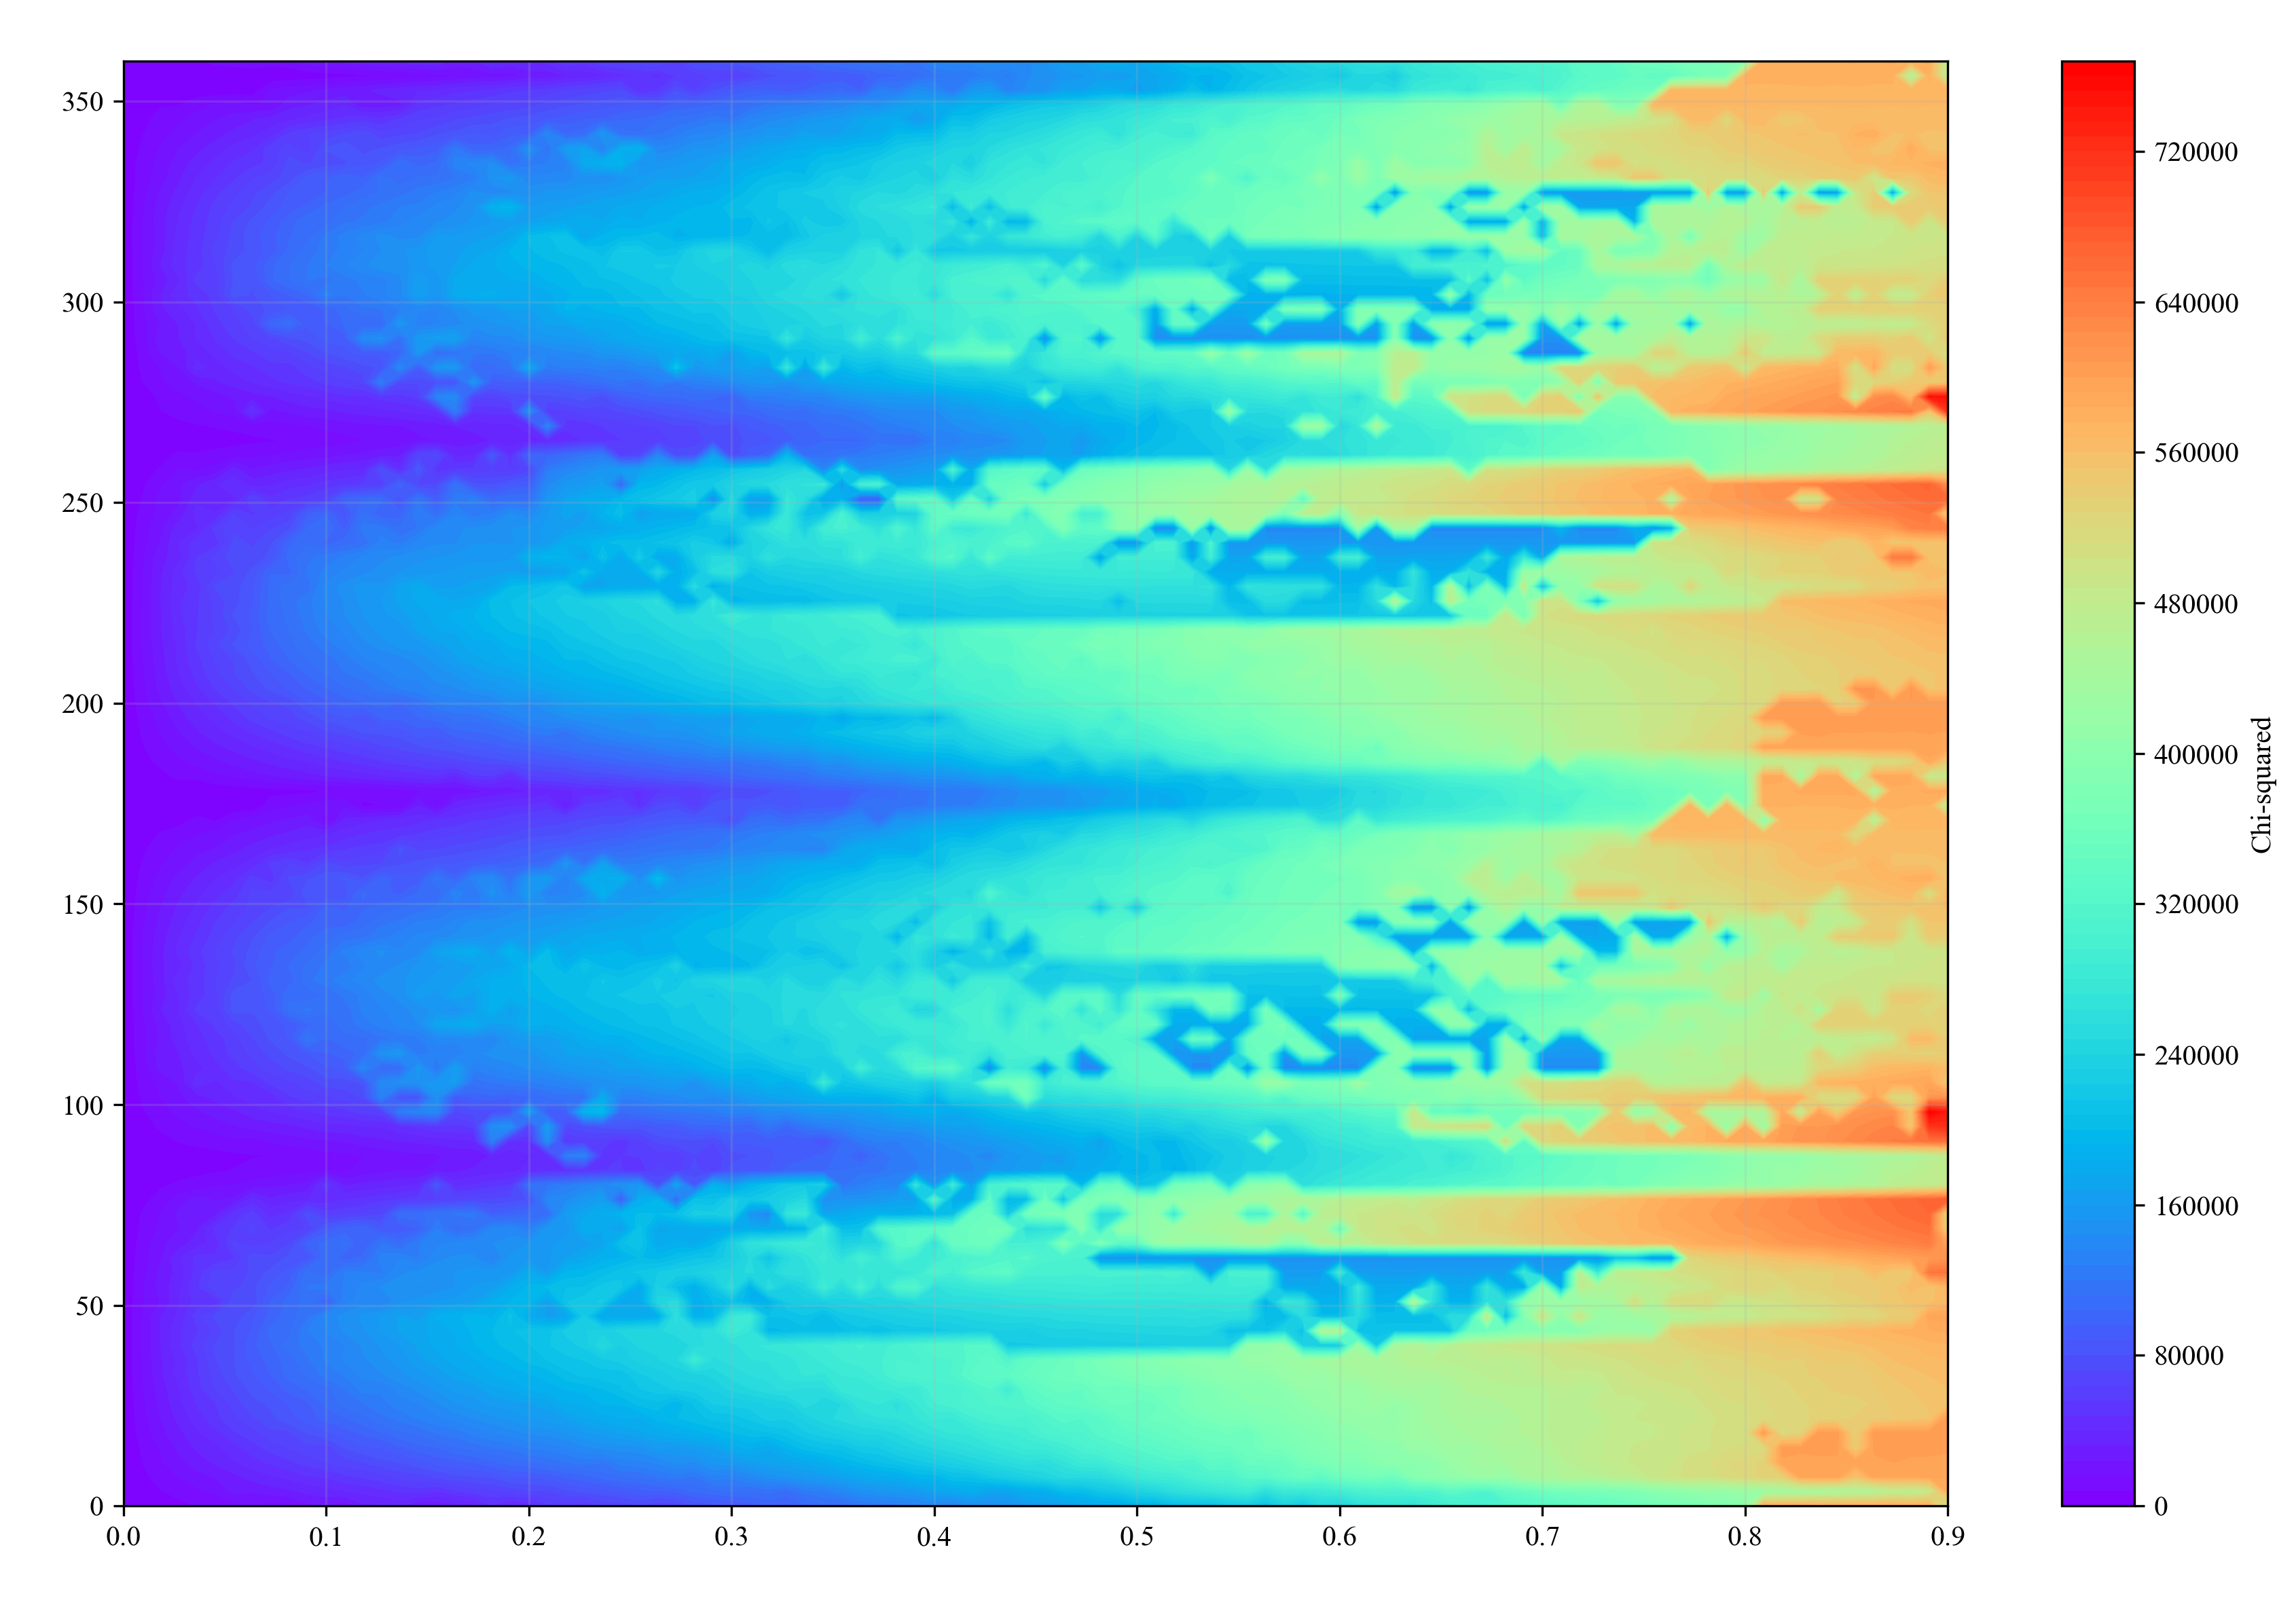

In [17]:
# Create a grid of x and y values
x = data['e'].values
y = data['$θ_{e}$'].values
z = data['chi2'].values

# Remove NaN values
mask = ~np.isnan(z)
x = x[mask]
y = y[mask]
z = z[mask]

# Create interpolation grid
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate z values on regular grid
zi = griddata((x, y), z, (xi, yi), method='cubic')

plt.figure(figsize=(12, 8))

# Create the contour plot using the same data
contour = plt.contourf(xi, yi, zi, levels=100, cmap='rainbow')

# Add a colorbar
plt.colorbar(contour, label='Chi-squared')

# Set labels and title
plt.xlabel('e', color = 'w')
plt.ylabel('$θ_{e}$', color = 'w')
plt.title('Ellipticity v/s PA', color = 'w')

# Set the style for dark theme
plt.grid(True, alpha=0.2)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [18]:
x_variable = 'e'
y_variable = '$θ_{e}$'
z_variable = 'c or $r_{s}$'
color_variable = 'chi2'
variable_to_animate = 'e' # The variable whose unique values will define the frames

fps = 10 # Frames per second for the output video. Adjust for desired speed.
# --- End of Configuration ---


# --- The rest of the code is now general ---

# Create a directory to store the frames
frames_dir = f'frames_3D_{color_variable}_vs_{x_variable}_{y_variable}_{z_variable}_over_{variable_to_animate}'
if os.path.exists(frames_dir):
    shutil.rmtree(frames_dir) # Clean up previous frames
os.makedirs(frames_dir)

# Determine global ranges for axes and color to keep the plot consistent
x_min, x_max = data[x_variable].min(), data[x_variable].max()
y_min, y_max = data[y_variable].min(), data[y_variable].max()
z_min, z_max = data[z_variable].min(), data[z_variable].max()
color_min, color_max = data[color_variable].min(), data[color_variable].max()

# Get the unique values to iterate over
values_to_iterate = sorted(data[variable_to_animate].unique())
print(f"Found {len(values_to_iterate)} unique values of '{variable_to_animate}' to animate.")

frame_files = []
print("Generating frames...")

for i, value in enumerate(values_to_iterate):
    # Filter the data to get points ONLY for the current unique value
    data_subset = data[data[variable_to_animate] == value]

    # Skip if there's no data for this value
    if data_subset.empty:
        continue

    # --- Create the 3D Plot for the current frame ---
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Create the 3D scatter plot
    scatter = ax.scatter(
        data_subset[x_variable],
        data_subset[y_variable],
        data_subset[z_variable],
        c=data_subset[color_variable],
        cmap='viridis',
        vmin=color_min,
        vmax=color_max,
        s=50 # Marker size
    )

    # Set labels and title dynamically
    ax.set_xlabel(x_variable)
    ax.set_ylabel(y_variable)
    ax.set_zlabel(z_variable)
    ax.set_title(f'{variable_to_animate} = {value:.3f}')

    # Set consistent axis limits for all frames
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)

    # Add a color bar
    cbar = fig.colorbar(scatter, shrink=0.7)
    cbar.set_label(color_variable)

    # Set a consistent viewing angle
    ax.view_init(elev=25., azim=45)
    plt.tight_layout()

    # Save the frame
    frame_path = os.path.join(frames_dir, f"frame_{i:04d}.png")
    plt.savefig(frame_path)
    plt.close(fig)  # Close the plot to free memory
    frame_files.append(frame_path)

print(f"Generated {len(frame_files)} frames.")

# Create the video from the frames
if frame_files:
    video_filename = f'{SIM_NAME}_{color_variable}_vs_{x_variable}_{y_variable}_{z_variable}_over_{variable_to_animate}.mp4'
    clip = mp.ImageSequenceClip(frame_files, fps=fps)
    clip.write_videofile(video_filename, codec='libx264')
    print(f"\nVideo saved as {video_filename}")

    # Clean up the frames directory
    shutil.rmtree(frames_dir)
else:
    print("No frames were generated, so no video was created.")

Found 100 unique values of 'e' to animate.
Generating frames...
Generated 100 frames.
MoviePy - Building video Sim 3_chi2_vs_e_$θ_{e}$_c or $r_{s}$_over_e.mp4.
MoviePy - Writing video Sim 3_chi2_vs_e_$θ_{e}$_c or $r_{s}$_over_e.mp4



MoviePy - Done !
MoviePy - video ready Sim 3_chi2_vs_e_$θ_{e}$_c or $r_{s}$_over_e.mp4

Video saved as Sim 3_chi2_vs_e_$θ_{e}$_c or $r_{s}$_over_e.mp4


In [20]:
# --- Configuration ---
# Select the variables for the animation
variable_to_animate = 'c or $r_{s}$' # Column to iterate over for each frame
x_variable = 'e'                  # Column for the x-axis
y_variable = '$θ_{e}$'             # Column for the y-axis
z_variable = 'chi2'            # Column for the color value (z-axis)
# --- End of Configuration ---


# --- The rest of the code is now general ---

# Create a directory to store the frames, named after the chosen variables
frames_dir = f'frames_contour_{z_variable}_vs_{x_variable}_{y_variable}_over_{variable_to_animate}'
if os.path.exists(frames_dir):
    shutil.rmtree(frames_dir) # Clean up previous frames
os.makedirs(frames_dir)

frame_files = []
values_to_iterate = sorted(data[variable_to_animate].unique())

# Determine the global range for the z-variable to keep the color bar consistent
z_min = data[z_variable].min()
z_max = data[z_variable].max()

for i, value in enumerate(values_to_iterate):
    data_subset = data[data[variable_to_animate] == value]

    # Skip if there's not enough data to create a grid
    if data_subset.shape[0] < 4:
        continue

    # Create a grid of x and y values
    x = data_subset[x_variable].values
    y = data_subset[y_variable].values
    z = data_subset[z_variable].values

    # Remove NaN values from the data
    mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isnan(z)
    x, y, z = x[mask], y[mask], z[mask]
    
    # Skip if not enough valid data points for interpolation
    if len(x) < 4:
        continue

    # Create interpolation grid
    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate z values on regular grid
    zi = griddata((x, y), z, (xi, yi), method='cubic')

    # Create the plot
    plt.figure(figsize=(12, 8))
    contour = plt.contourf(xi, yi, zi, levels=100, cmap='rainbow', vmin=z_min, vmax=z_max)
    plt.colorbar(contour, label=z_variable)
    
    # Set labels and title dynamically
    plt.xlabel(x_variable)
    plt.ylabel(y_variable)
    plt.title(f'{z_variable} vs. {x_variable} and {y_variable} for {variable_to_animate} = {value:.2f}')
    plt.grid(True, alpha=0.2)
    plt.tight_layout()

    # Save the frame
    frame_path = os.path.join(frames_dir, f"frame_{i:04d}.png")
    plt.savefig(frame_path)
    plt.close()  # Close the plot to free memory
    frame_files.append(frame_path)

# Create the video from the frames
if frame_files:
    clip = mp.ImageSequenceClip(frame_files, fps=10) # Adjusted fps for better viewing
    video_filename = f'{SIM_NAME}_{z_variable}_vs_{x_variable}_{y_variable}_over_{variable_to_animate}_animation.mov'
    clip.write_videofile(video_filename, codec='libx264')
    print(f"Video saved as {video_filename}")

    # Clean up the frames directory
    shutil.rmtree(frames_dir)
else:
    print("No frames were generated to create a video.")

MoviePy - Building video Sim 3_chi2_vs_e_$θ_{e}$_over_c or $r_{s}$_animation.mov.
MoviePy - Writing video Sim 3_chi2_vs_e_$θ_{e}$_over_c or $r_{s}$_animation.mov



MoviePy - Done !
MoviePy - video ready Sim 3_chi2_vs_e_$θ_{e}$_over_c or $r_{s}$_animation.mov
Video saved as Sim 3_chi2_vs_e_$θ_{e}$_over_c or $r_{s}$_animation.mov


In [27]:
# Select the variable to iterate over for the animation
variable_to_animate = 'e'

# Select the variable to plot the KDE for
variable_to_plot = 'pos_rms' # e.g., 'pos_rms', 'mag_rms', 'chi2'

# --- The rest of the code is now general ---

# Create a directory to store the frames, named after the chosen variables
frames_dir = f'frames_kde_{variable_to_plot}_vs_{variable_to_animate}'
if os.path.exists(frames_dir):
    shutil.rmtree(frames_dir) # Clean up previous frames
os.makedirs(frames_dir)

frame_files = []
values = sorted(data[variable_to_animate].unique())

# Determine the global range for the plotted variable to keep the x-axis consistent
plot_var_min = 0
plot_var_max = 1

for i, value in enumerate(values):
    # Filter data for the current value of the chosen animation variable
    data_subset = data[data[variable_to_animate] == value]

    # Skip if there's not enough data
    if data_subset.empty:
        continue

    plt.figure(figsize=(8, 4))
    sns.kdeplot(data_subset[variable_to_plot], fill=True)
    
    # Set labels and a dynamic title
    plt.title(f'KDE of {variable_to_plot} for {variable_to_animate} = {value:.2f}')
    plt.xlabel(variable_to_plot)
    plt.ylabel('Density')
    plt.xlim(0, 1) # Keep x-axis consistent
    plt.ylim(0, 5.0) # Let y-axis adjust automatically
    plt.grid(True, alpha=0.2)
    plt.tight_layout()

    # Save the frame
    frame_path = os.path.join(frames_dir, f"frame_{i:04d}.png")
    plt.savefig(frame_path)
    plt.close()  # Close the plot to free memory
    frame_files.append(frame_path)

# Create the video from the frames
if frame_files:
    clip = mp.ImageSequenceClip(frame_files, fps=10) # Slower fps for better viewing
    video_filename = f'{SIM_NAME}_kde_{variable_to_plot}_vs_{variable_to_animate}_animation.mov'
    clip.write_videofile(video_filename, codec='libx264')
    print(f"Video saved as {video_filename}")

    # Clean up the frames directory
    shutil.rmtree(frames_dir)
else:
    print("No frames were generated to create a video.")

MoviePy - Building video Sim 3_kde_pos_rms_vs_e_animation.mov.
MoviePy - Writing video Sim 3_kde_pos_rms_vs_e_animation.mov



MoviePy - Done !
MoviePy - video ready Sim 3_kde_pos_rms_vs_e_animation.mov
Video saved as Sim 3_kde_pos_rms_vs_e_animation.mov
